# HW6

In [40]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

chess = fetch_ucirepo(id=23)
df = pd.concat([chess.data.features, chess.data.targets], axis=1)
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


## Przygotowanie danych

Mapowanie pozycji (a-h) na liczby (1-8) oraz obliczenie metryk dystansu.

In [ ]:
file_mapping = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8}
df['white-king-file'] = df['white-king-file'].map(file_mapping)
df['white-rook-file'] = df['white-rook-file'].map(file_mapping)
df['black-king-file'] = df['black-king-file'].map(file_mapping)

depth_mapping = {
    'draw': -1, 'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
    'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, 'thirteen': 13, 'fourteen': 14, 
    'fifteen': 15, 'sixteen': 16
}
df['white-depth-of-win'] = df['white-depth-of-win'].map(depth_mapping)

df['euclidean_dist'] = np.sqrt((df['white-king-file'] - df['black-king-file'])**2 + (df['white-king-rank'] - df['black-king-rank'])**2)
df['manhattan_dist'] = np.abs(df['white-king-file'] - df['black-king-file']) + np.abs(df['white-king-rank'] - df['black-king-rank'])
df['chebyshev_dist'] = np.maximum(np.abs(df['white-king-file'] - df['black-king-file']), np.abs(df['white-king-rank'] - df['black-king-rank']))
df['edge_dist'] = np.minimum(np.minimum(df['black-king-file'] - 1, 8 - df['black-king-file']), np.minimum(df['black-king-rank'] - 1, 8 - df['black-king-rank']))
df.head()

,white-king-file,white-king-rank,white-rook-file,white-rook-rank,black-king-file,black-king-rank,white-depth-of-win,euclidean_dist,manhattan_dist,chebyshev_dist,edge_dist
0,1,1,2,3,3,2,-1,2.236068,3,2,1
1,1,1,3,1,3,2,-1,2.236068,3,2,1
2,1,1,3,1,4,1,-1,3.000000,3,3,0
3,1,1,3,1,4,2,-1,3.162278,4,3,1
4,1,1,3,2,3,1,-1,2.000000,2,2,0


## Pytanie 1
**Gdzie zwykle znajduje się na planszy czarny król, kiedy jest matowany (white-depth-of-win=0)? Gdzie znajduje się, kiedy gra kończy się remisem (white-depth-of-win=-1)?**

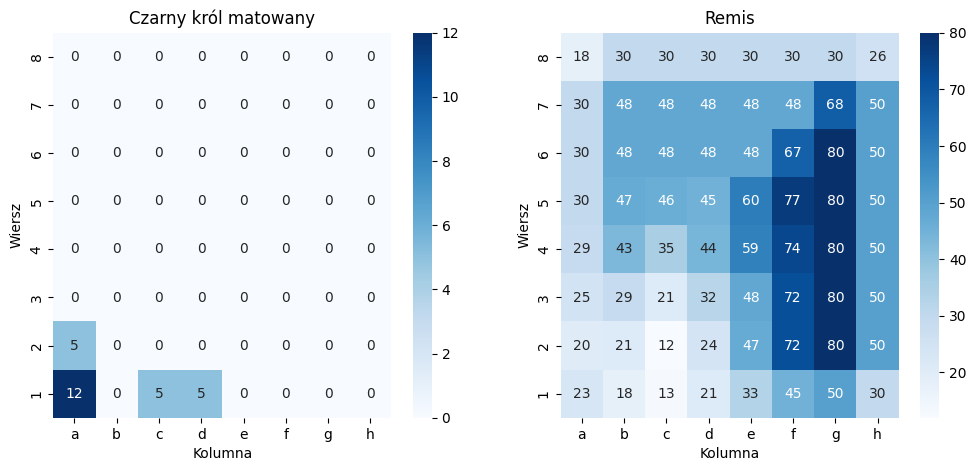

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
subset0 = df[df['white-depth-of-win'] == 0]
counts0 = pd.crosstab(subset0['black-king-rank'], subset0['black-king-file']).reindex(index=range(8, 0, -1), columns=range(1, 9), fill_value=0)
sns.heatmap(counts0, ax=axes[0], cmap='Blues', annot=True, xticklabels=list('abcdefgh'), yticklabels=range(8, 0, -1))
axes[0].set_title('Czarny król matowany')
axes[0].set_xlabel('Kolumna')
axes[0].set_ylabel('Wiersz')
subset1 = df[df['white-depth-of-win'] == -1]
counts1 = pd.crosstab(subset1['black-king-rank'], subset1['black-king-file']).reindex(index=range(8, 0, -1), columns=range(1, 9), fill_value=0)
sns.heatmap(counts1, ax=axes[1], cmap='Blues', annot=True, xticklabels=list('abcdefgh'), yticklabels=range(8, 0, -1))
axes[1].set_title('Remis')
axes[1].set_xlabel('Kolumna')
axes[1].set_ylabel('Wiersz')
plt.show()

### Komentarz 1

Czarny król, kiedy jest matowany: Czarny król najczęściej znajduje się w lewym dolnym rogu planszy (a1, a2, c1, d1). 

Remis: Czarny król najczęściej jest w kolumnach g/f i rzędach 2-6

## Pytanie 2
**Jaka metryka dystansu (Euklidesowa, Manhattan, lub Czebyszewa) pomiędzy nimi pozwoli najlepiej oszacować liczbę ruchów do zakończenia gry?**

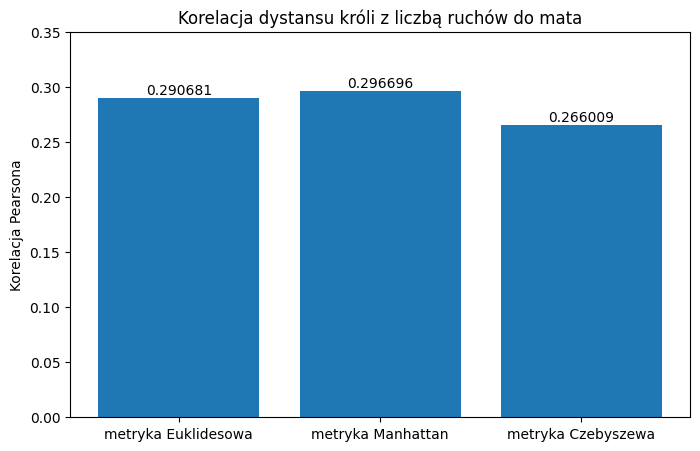

In [43]:
df_wins = df[df['white-depth-of-win'] != -1]
correlations = {
    'metryka Euklidesowa': df_wins['euclidean_dist'].corr(df_wins['white-depth-of-win']),
    'metryka Manhattan': df_wins['manhattan_dist'].corr(df_wins['white-depth-of-win']),
    'metryka Czebyszewa': df_wins['chebyshev_dist'].corr(df_wins['white-depth-of-win'])
}
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(correlations.keys(), correlations.values())
ax.set_ylabel('Korelacja Pearsona')
ax.set_title('Korelacja dystansu króli z liczbą ruchów do mata')
ax.bar_label(bars)
ax.set_ylim(0, 0.35)
plt.show()

### Komentarz 2

Każda z trzech metryk ma podobną korelację z liczbą ruchów, jednak najwyższą korelację ma metryka Manhattan ~0.297, zatem najlepiej oszacuje liczbę ruchów do zakończenia gry.
Dodatkowo król oraz wieża poruszają się po liniach prostych, co dosyć intuicyjnie wyjaśnia przewagę metryki Manhattan.

## Pytanie 3
**Czy informacja o odległości czarnego króla od krawędzi planszy może być przydatna w określeniu w ilu ruchach zakończy się gra? Czy uzupełnienie tej informacji o odległość pomiędzy białym a czarnym królem z poprzedniego zadania może dodatkowo pomóc?**

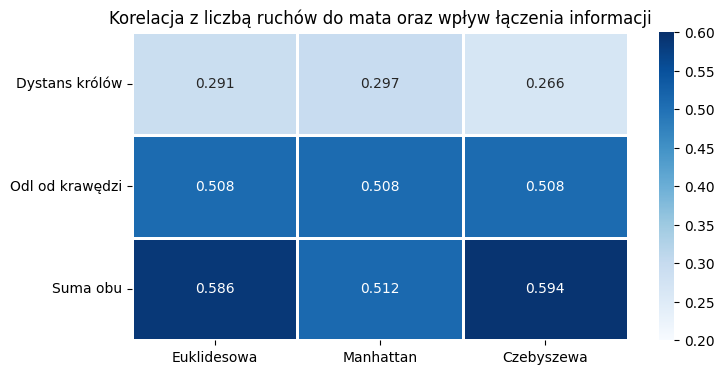

                 Euklidesowa  Manhattan  Czebyszewa
Dystans królów      0.290681   0.296696    0.266009
Odl od krawędzi     0.508439   0.508439    0.508439
Suma obu            0.585982   0.512413    0.593595


In [44]:
df_wins = df_wins.copy()
df_wins['sum_euclid'] = df_wins['edge_dist'] + df_wins['euclidean_dist']
df_wins['sum_manhattan'] = df_wins['edge_dist'] + df_wins['manhattan_dist']
df_wins['sum_chebyshev'] = df_wins['edge_dist'] + df_wins['chebyshev_dist']
depth = df_wins['white-depth-of-win']
corr_data = {
    'Euklidesowa': [
        df_wins['euclidean_dist'].corr(depth),
        df_wins['edge_dist'].corr(depth),
        df_wins['sum_euclid'].corr(depth)
    ],
    'Manhattan': [
        df_wins['manhattan_dist'].corr(depth),
        df_wins['edge_dist'].corr(depth),
        df_wins['sum_manhattan'].corr(depth)
    ],
    'Czebyszewa': [
        df_wins['chebyshev_dist'].corr(depth),
        df_wins['edge_dist'].corr(depth),
        df_wins['sum_chebyshev'].corr(depth)
    ]
}
df_corr = pd.DataFrame(corr_data, index=['Dystans królów', 'Odl od krawędzi', 'Suma obu'])
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(df_corr, annot=True, cmap='Blues', fmt='.3f', linewidths=1, ax=ax, vmin=0.2, vmax=0.6)
ax.set_title('Korelacja z liczbą ruchów do mata oraz wpływ łączenia informacji')
plt.show()
print(df_corr)

### Komentarz  3
Czy odległość czarnego króla od krawędzi jest przydatna?

Tak, ogólnie to korelacja z liczbą ruchów wynosi ~0.508. Im bliżej krawędzi znajduje się czarny król, tym szybciej kończy się gra.

Czy połączenie z odległością między królami pomaga?

Tak – korelacja z liczbą ruchów do mata wynosi ~0.508. Im bliżej krawędzi znajduje się czarny król, tym szybciej biały wygrywa. Jest to najsilniejszy pojedynczy predyktor spośród badanych cech.

Czy połączenie z odległością między królami pomaga?

Tak, ale raczje nieznacznie oraz w różnym stopniu w zależności od metryki. Suma obu cech daje korelację:
- Euklidesowa: 0.58
- Manhattan: 0.512 
- Czebyszewa: 0.594

Połączenie cech najbardziej pomaga dla metryki Czebyszewa (+0.086), 
rówinie trochę pomaga dla metyrki Euklidesowej (+0.078),natomiast dla Manhattan praktycznie nie ma większej róznicy.